# Transfer Learning
Code taken from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

What is transfer learning?
In case you already have a pretrained model, you can use it in your model in two ways:
1. Fine tuning the model to fit your problem. 
Which means that the pretrained model is learning as usual, it just not using a random weight at start.
2. As a fixed feature extractor. 
Freezing all the pretrained weights, so it's not training anymore. What we want to train is the result of that model. So after the last layer of pretrained model, we add second layer that actually do the mapping from it to our output.

In [3]:
# sys module
from __future__ import print_function, division
import time
import os
import copy

# third parties module
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt

plt.ion()   # interactive mode
path_this = os.path.abspath (os.path.dirname ('.'))

In [38]:
# specify transformation
data_transforms = {
    'train' : transforms.Compose ([
        transforms.RandomResizedCrop (224), # Crop the image randomly, and then resized to (244x244)
        transforms.RandomHorizontalFlip (),
        transforms.ToTensor (),
        transforms.Normalize ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose ([
        transforms.Resize (256),
        transforms.CenterCrop (224), # Crop in the center, and output (224x224)
        transforms.ToTensor (),
        transforms.Normalize ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
}

data_dir = os.path.join (path_this, '..', 'data', 'hymenoptera_data')

image_datasets = {
                x: datasets.ImageFolder (
                        os.path.join (data_dir, x), 
                        data_transforms[x])
                 for x in ['train', 'val']
    }

Datasets is just list of data. In order to feed it into the network, we need batch. So, we convert it to batches by using loader.

In [39]:
dataloaders = {
        x: torch.utils.data.DataLoader (
            image_datasets[x], 
            batch_size=4, 
            shuffle=True, 
            num_workers=4
        ) for x in ['train', 'val']
    }

dataset_sizes = {x: len (image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device ('cuda' if torch.cuda.is_available () else "cpu")
print ("Classes : ", class_names)
print ("Device  : ", device)

Classes :  ['ants', 'bees']
Device  :  cuda


Lets try some visualization!

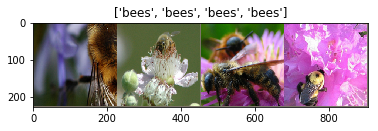

In [40]:
def imshow (inp, title=None):
    inp = inp.numpy ().transpose ((1,2,0)) #?
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip (inp, 0, 1) # ?
    plt.imshow (inp)
    if title:
        plt.title (title)
    plt.pause (0.001)

inputs, classes = (next (iter (dataloaders['train'])))
out = torchvision.utils.make_grid (inputs)
imshow (out, title=[class_names[x] for x in classes])

Now we will train it, by using learning rate scheduler and save the best model.
Learning rate scheduler is a method to change the learning rate at k iteration.

In [45]:
def train_model (
        model, # architecture
        criterion, # objective function
        optimizer, # weight learning 
        scheduler, 
        num_epochs=25) :
    
    t_start = time.time ()
    best_model_wts = copy.deepcopy (model.state_dict ())
    best_acc= 0.0
    
    for epoch in range (num_epochs):
        print ("Epoch {}/{}".format (epoch, num_epochs-1))
        print ("-" * 10)
        
        # in each epoch, there are training and validation
        for phase in ['train', 'val']:
            if phase == 'train' : 
                scheduler.step ()
                model.train ()
            else:
                model.eval ()
                
            running_loss = 0.0
            running_acc = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to (device)
                labels = labels.to (device)
                
                optimizer.zero_grad ()
                
                # forward
                # only enable gradient in train mode
                with torch.set_grad_enabled (phase == 'train'):
                    outputs = model (inputs)
                    _, preds = torch.max (outputs, 1)
                    loss = criterion (outputs, labels)
                    
                    # backward and optimization in train only
                    if phase == 'train':
                        loss.backward ()
                        optimizer.step ()
                
                running_loss += loss.item () * inputs.size (0)
                running_acc += torch.sum (preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_acc.double () / dataset_sizes[phase]
            
            print ("{} Loss : {:.4f} Acc : {:.4f}".format (
                phase, epoch_loss, epoch_acc
            ))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy (model.state_dict ())
        print ()
        
    duration = time.time () - t_start
    print ("Training complete in {:.0f}m {:.2f}s".format (
        duration // 60, duration % 60
    ))
    print ("Best accuracy : {:.2F}".format (best_acc))
    
    model.load_state_dict (best_model_wts)
    return model
                

# Fine Tuning The Resnet
In this experiment, the resnet weight will be updated to learn from our data.

Since the output of original resnet and our problem is different, we have to change the final layer of it.

For some reason, since we are using a pretrained model, we don't need to train for a long time.
In this experiment, we just train it for a few times to get the best model.

In [43]:
# now we use resnet model to train it
model_ft = models.resnet18 (pretrained=True)
num_feat = model_ft.fc.in_features # we take the last input dimension
model_ft.fc = nn.Linear (num_feat, 2) # and change the output dimension

model_ft = model_ft.to (device)
loss_fn = nn.CrossEntropyLoss ()
optimizer = optim.SGD (model_ft.parameters (), lr=0.001, momentum=0.9)

# decay the LR by 0.1 every 7 epoch
exp_lr_scheduler = lr_scheduler.StepLR (optimizer, step_size=7, gamma=0.1)

In [46]:
model_ft = train_model (model_ft, loss_fn, optimizer, 
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss : 0.2762 Acc : 0.8566
val Loss : 0.2563 Acc : 0.9412

Epoch 1/24
----------
train Loss : 0.2637 Acc : 0.8934
val Loss : 0.2339 Acc : 0.9477

Epoch 2/24
----------
train Loss : 0.3043 Acc : 0.8648
val Loss : 0.2498 Acc : 0.9346

Epoch 3/24
----------
train Loss : 0.2365 Acc : 0.9098
val Loss : 0.2817 Acc : 0.8954

Epoch 4/24
----------
train Loss : 0.3336 Acc : 0.8525
val Loss : 0.2239 Acc : 0.9477

Epoch 5/24
----------
train Loss : 0.3046 Acc : 0.8443
val Loss : 0.2517 Acc : 0.9346

Epoch 6/24
----------
train Loss : 0.2379 Acc : 0.8811
val Loss : 0.2718 Acc : 0.9281

Epoch 7/24
----------
train Loss : 0.2828 Acc : 0.8893
val Loss : 0.2736 Acc : 0.9216

Epoch 8/24
----------
train Loss : 0.2513 Acc : 0.8975
val Loss : 0.2363 Acc : 0.9346

Epoch 9/24
----------
train Loss : 0.2435 Acc : 0.8893
val Loss : 0.2314 Acc : 0.9477

Epoch 10/24
----------
train Loss : 0.2554 Acc : 0.8648
val Loss : 0.2578 Acc : 0.9216

Epoch 11/24
----------
train Loss : 0.2281

# Resnet As Feature Extraction
The next use case of transfer learning is to use the weight as it is. 
No updated of the original resnet weight required, but we still need to change the last fc layer.

In [47]:
model_static = models.resnet18 (pretrained=True)
for param in model_static.parameters ():
    param.require_grad = False # disable learning
    
fc_feat = model_static.fc.in_features
model_static.fc = nn.Linear (fc_feat, 2)

model_static = model_static.to (device)
loss_fn = nn.CrossEntropyLoss ()

# do observe that optimization only set to the last layer
# not the whole model
optimizer = optim.SGD (model_static.fc.parameters (), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR (optimizer, step_size=7, gamma=0.1)

In [50]:
model_conv = train_model (model_static, loss_fn, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss : 0.6876 Acc : 0.5943
val Loss : 0.2340 Acc : 0.9216

Epoch 1/24
----------
train Loss : 0.5417 Acc : 0.7623
val Loss : 0.2083 Acc : 0.9477

Epoch 2/24
----------
train Loss : 0.5421 Acc : 0.7541
val Loss : 0.4114 Acc : 0.8497

Epoch 3/24
----------
train Loss : 0.5018 Acc : 0.7951
val Loss : 0.1893 Acc : 0.9412

Epoch 4/24
----------
train Loss : 0.4907 Acc : 0.8074
val Loss : 0.2574 Acc : 0.8824

Epoch 5/24
----------
train Loss : 0.3934 Acc : 0.8320
val Loss : 0.1871 Acc : 0.9346

Epoch 6/24
----------
train Loss : 0.5812 Acc : 0.7787
val Loss : 0.2523 Acc : 0.8954

Epoch 7/24
----------
train Loss : 0.3868 Acc : 0.8361
val Loss : 0.1782 Acc : 0.9542

Epoch 8/24
----------
train Loss : 0.3543 Acc : 0.8566
val Loss : 0.1918 Acc : 0.9412

Epoch 9/24
----------
train Loss : 0.4264 Acc : 0.8361
val Loss : 0.1919 Acc : 0.9216

Epoch 10/24
----------
train Loss : 0.3347 Acc : 0.8361
val Loss : 0.2196 Acc : 0.9281

Epoch 11/24
----------
train Loss : 0.3383